In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, r'../..')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import imageio
import pickle
import os
from tqdm import tqdm_notebook as tqdm

from lib.video import *
from lib.utils import convert_time, start_table_to_dict, cur_frame, cur_time

In [3]:
from src.time_extractor import generate_static_mask, generate_green_mask

Use tqdm_notebook


In [4]:
UI_REAL = '../../data/test/real_start_test.csv'
UI_PREDICTION = '../../output/features/games_starts_test.csv'
VIDEO_DIR = '../../data/test/'
VIDEO = '645001_5.mp4'
VIDEO_PATH = VIDEO_DIR + 'resized_' + VIDEO
NONE_TYPE = 'NONE'
FULL_EVENT_TABLE = '../../data/test/' + 'events.csv'
GOOD_EVENTS = ['желтая карточка', 'гол', 'замена']

In [5]:
full_event_table = pd.read_csv(FULL_EVENT_TABLE)
full_event_table = full_event_table[full_event_table['event_type'].isin(GOOD_EVENTS)]
full_event_table

,file_name,event_type,event_time,event_end
0,645001_5.mp4,гол,1:39:54,1:39:58
1,645001_5.mp4,гол,1:46:11,1:46:15
2,645001_5.mp4,гол,17:36,17:40
3,645001_5.mp4,желтая карточка,1:31:33,1:31:39
4,645001_5.mp4,гол,1:32:31,1:32:35
5,645001_5.mp4,желтая карточка,13:47,13:52
6,645001_5.mp4,желтая карточка,45:58,46:02
7,645001_5.mp4,замена,1:20:26,1:20:36
8,645001_5.mp4,желтая карточка,1:23:27,1:23:32
9,645001_5.mp4,желтая карточка,1:34:12,1:34:17


In [6]:
FILES = full_event_table['file_name'].unique()
','.join(FILES)

'645001_5.mp4,645066_5.mp4,645098_5.mp4,645195_5.mp4,645286_5.mp4,645310_5.mp4'

In [145]:
green_mask = generate_green_mask(VIDEO_PATH, proportion=0.02)
show_img(green_mask)

A Jupyter Widget

KeyboardInterrupt: 

In [7]:
HL, WL, H, W = 5, 10, 30, 60
def filter_mask(ui_mask, k=0):
    ui_mask = ui_mask.copy()
    mask = np.ones_like(ui_mask)
    mask[HL:H, WL:W] = 0
    ui_mask[mask] = 0
    n, m = ui_mask.shape
    mask = np.zeros_like(ui_mask)
    for x in np.arange(k, n-k):
        for y in np.arange(k, m-k):
            for dx in np.arange(-k, k+1):
                for dy in np.arange(-k, k+1):
                    if ui_mask[x+dx][y+dy]:
                        mask[x][y] = 1
    ui_mask[mask] = 1
    return ui_mask

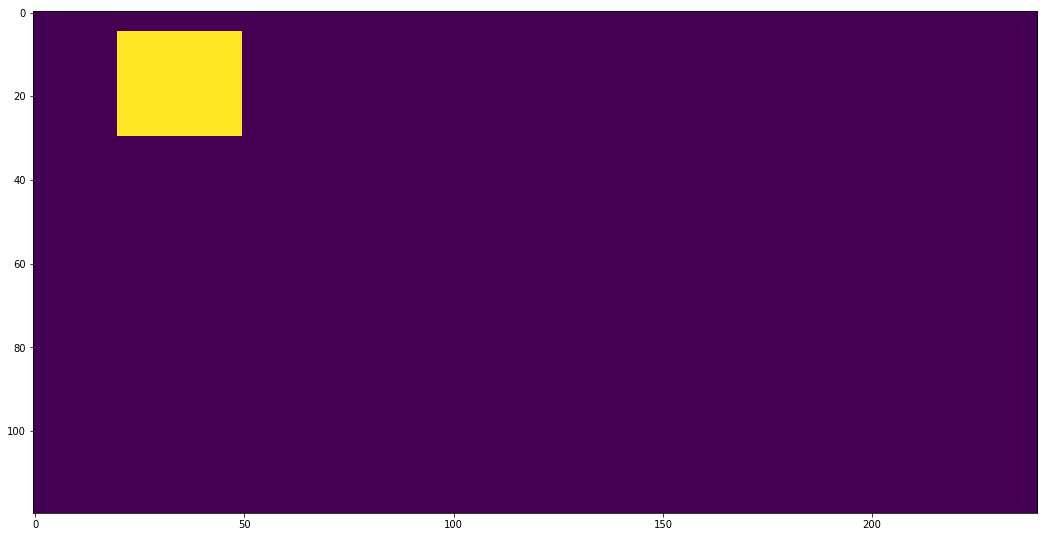

In [8]:
def gen_const_mask():
    mask = np.zeros((120, 240), 'bool')
    mask[5:30, 20:50] = True
    #mask[10:20, 20:35] = True
    return mask

UI_MASK = gen_const_mask()
show_img(gen_const_mask())

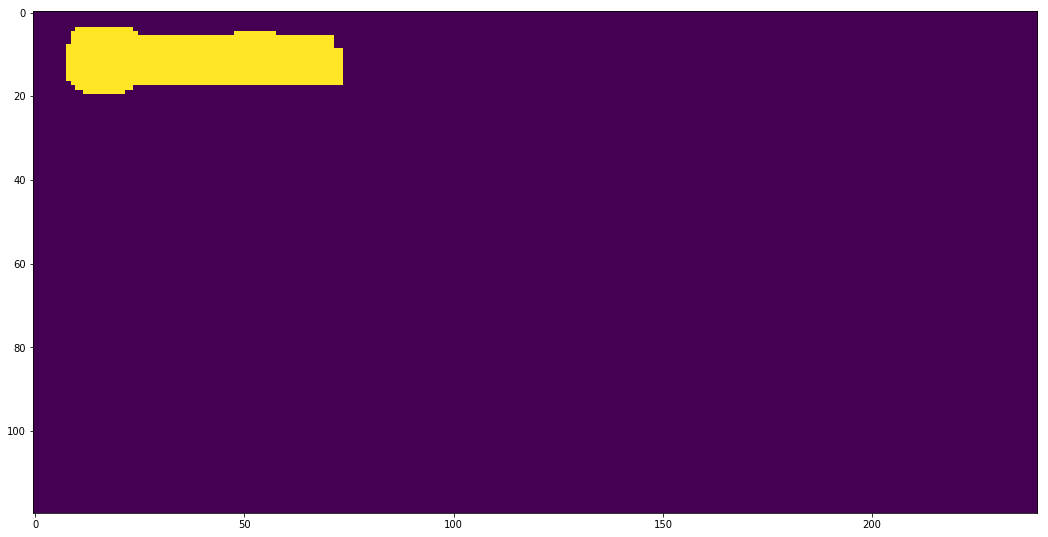

In [118]:
UI_MASK = filter_mask(green_mask, 4)
show_img(UI_MASK)

In [9]:
def preproc_same(frame):
    frame = np.array(frame, dtype='float')
    return frame

In [10]:
def preproc_mask(frame):
    frame = np.array(frame, dtype='float')
    frame[~UI_MASK] = 0
    frame = frame[HL:H, WL:W]
    return frame

In [11]:
PREPROC_FUN = preproc_mask
IS_FLATTEN = True
NONK = 20
NN = 1000

In [12]:
def show_event_imgs(file_name):
    path = VIDEO_DIR + 'resized_' + file_name
    n_frame = get_total_len(path)
    events_type = [None] * n_frame
    for _, row in full_event_table.iterrows():
        if row.file_name != file_name:
            continue
        l, r = convert_time(row.event_time)+2, convert_time(row.event_end)-1
        print(row.event_type, (l, r), r-l+1)
        for i in range(l, r+1):
            events_type[i] = row.event_type
    for frame, event_type in tqdm(zip(get_reader(path), events_type)):
        frame = PREPROC_FUN(frame)
        if event_type is not None:
            show_img(frame.astype('uint8'), k=0.5)
            plt.show()

гол (5996, 5997) 2
гол (6373, 6374) 2
гол (1058, 1059) 2
желтая карточка (5495, 5498) 4
гол (5553, 5554) 2
желтая карточка (829, 831) 3
желтая карточка (2760, 2761) 2
замена (4828, 4835) 8
желтая карточка (5009, 5011) 3
желтая карточка (5654, 5656) 3
желтая карточка (5753, 5756) 4


A Jupyter Widget

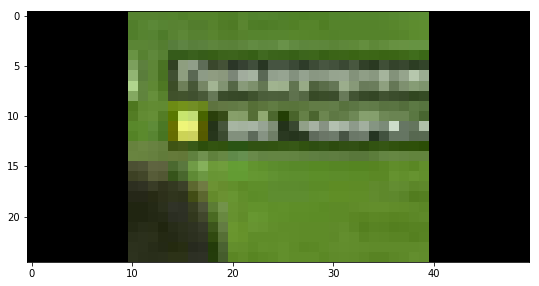

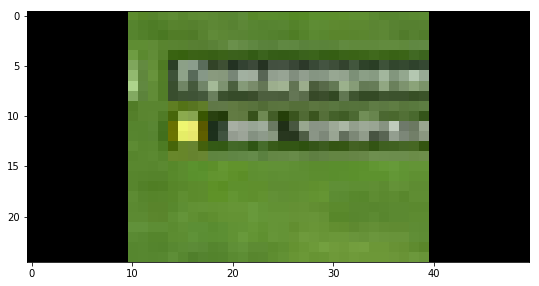

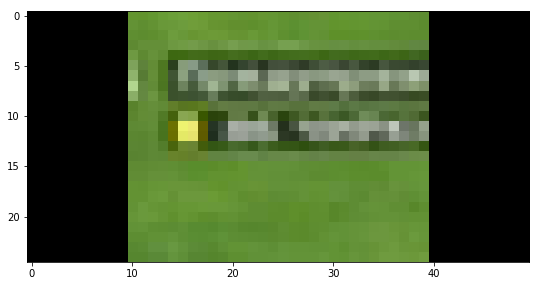

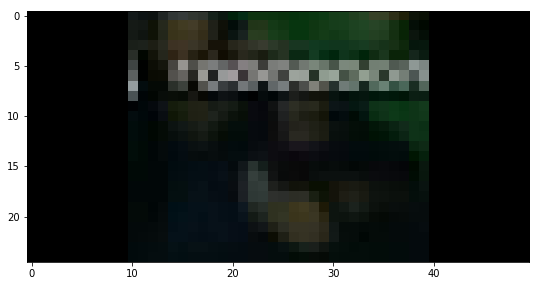

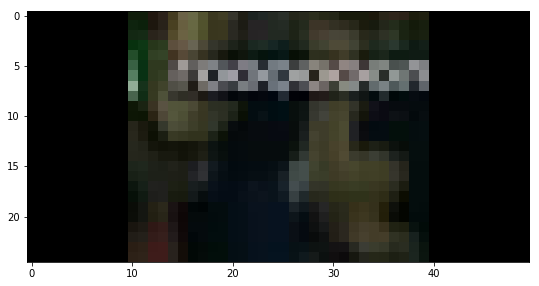

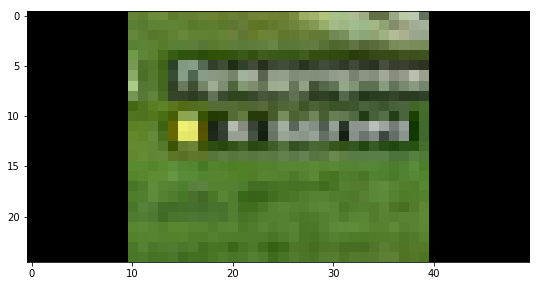

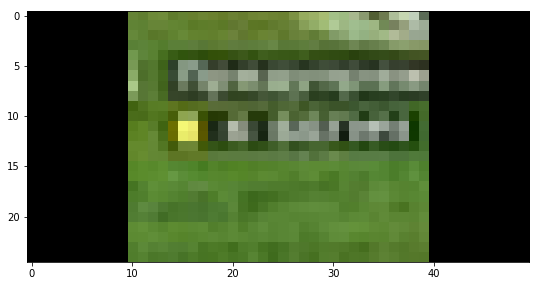

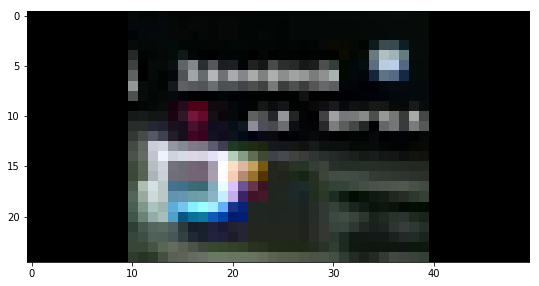

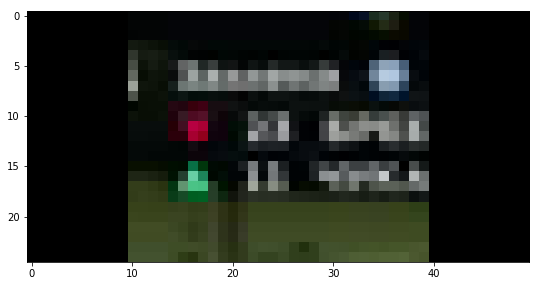

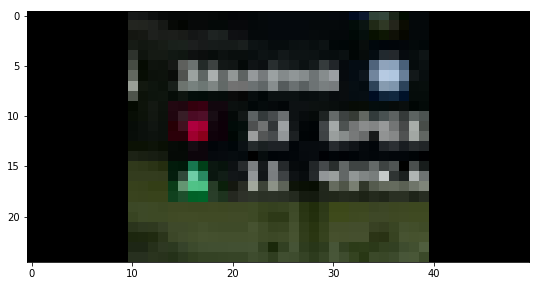

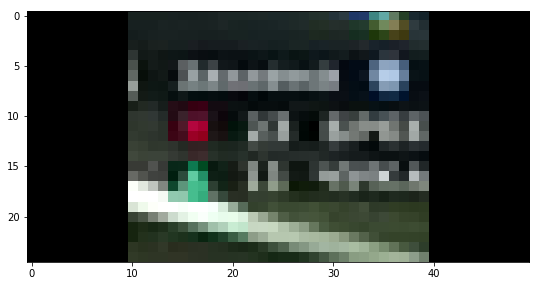

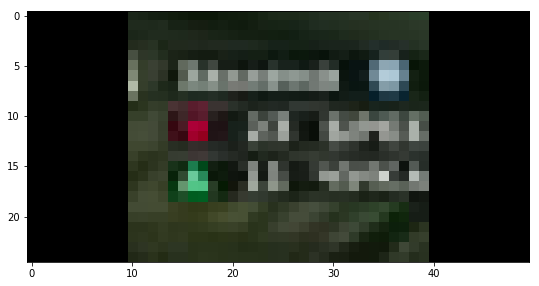

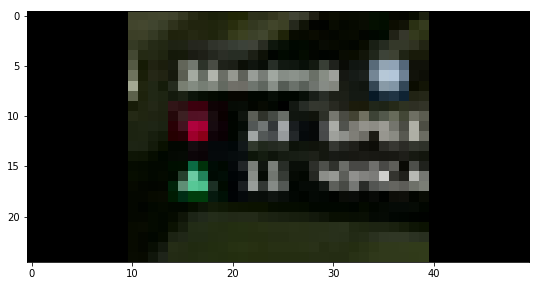

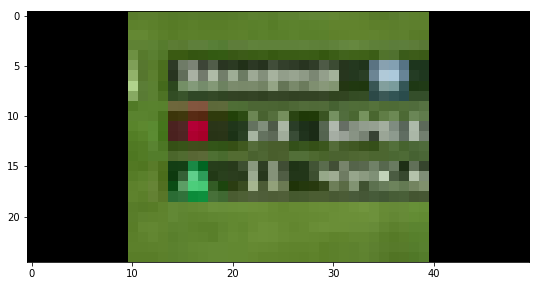

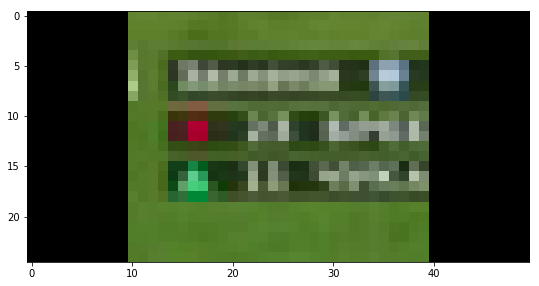

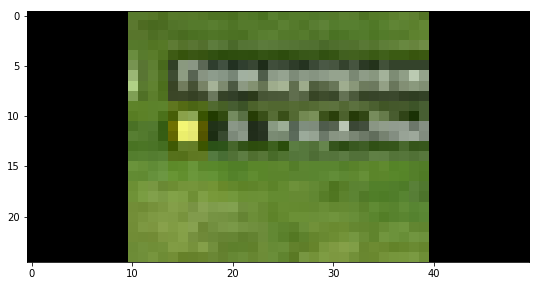

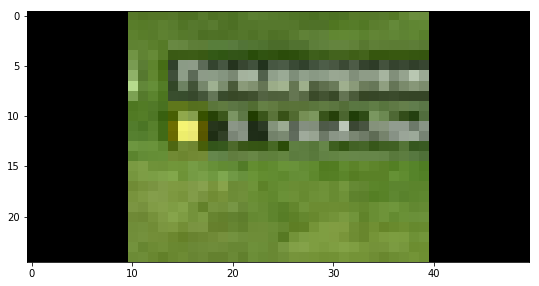

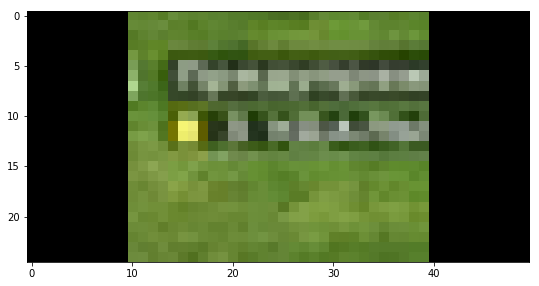

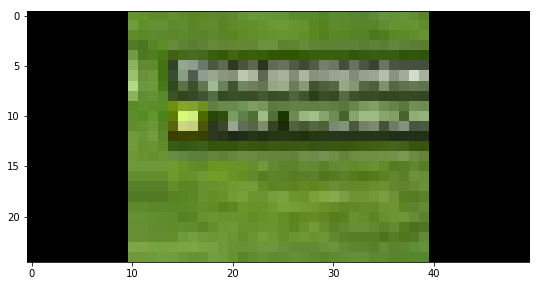

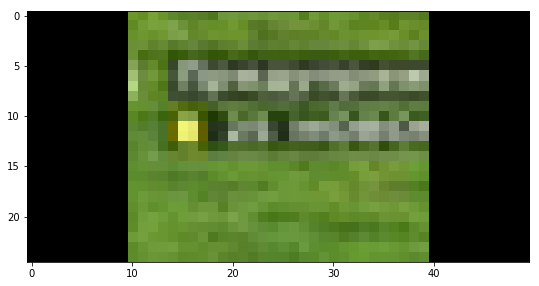

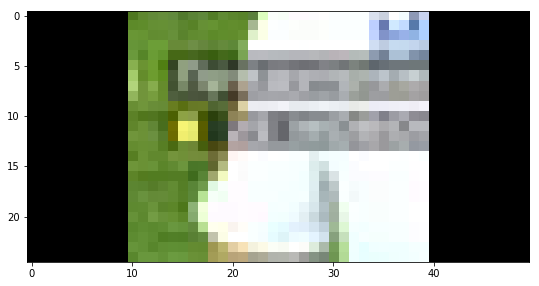

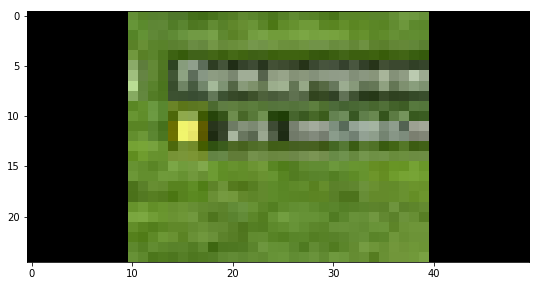

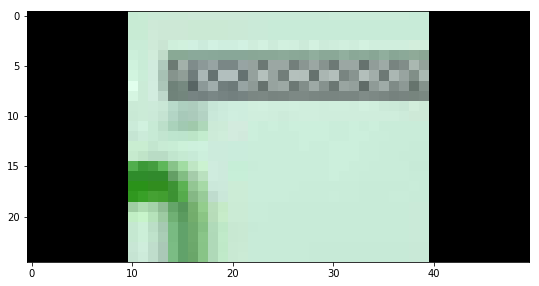

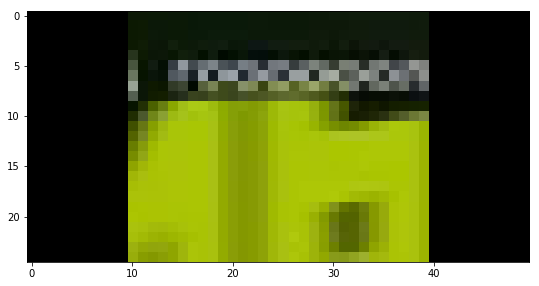

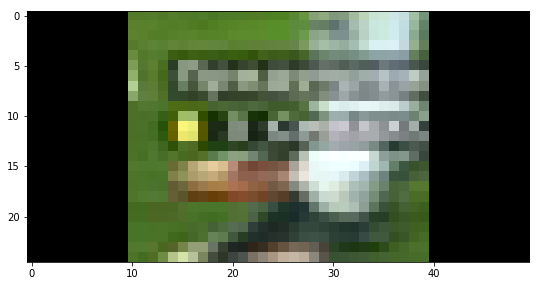

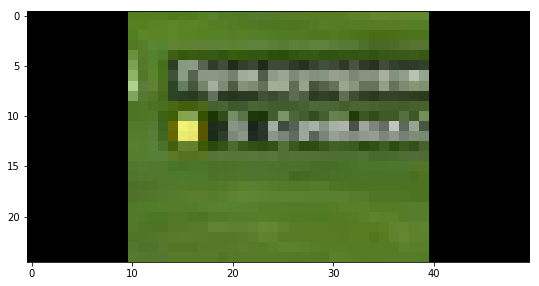

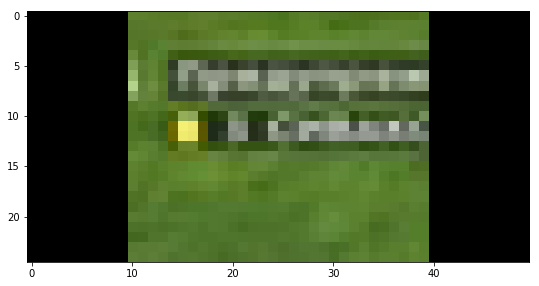

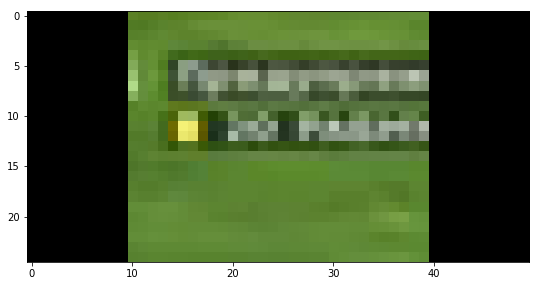

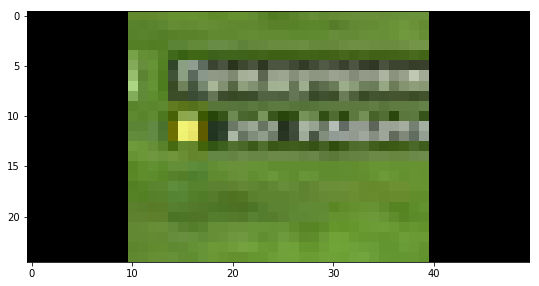

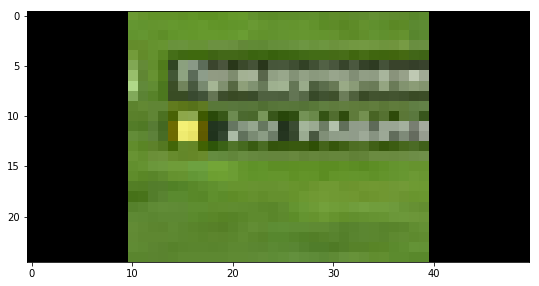

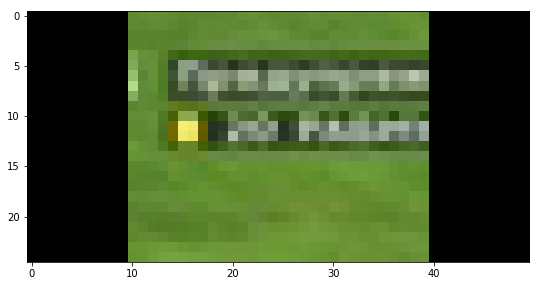

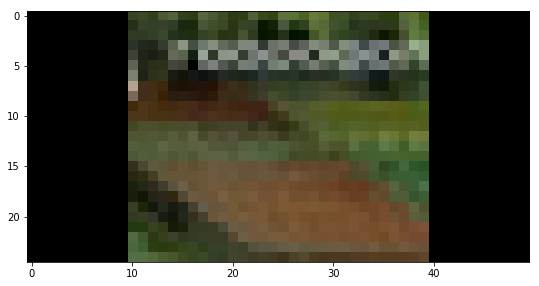

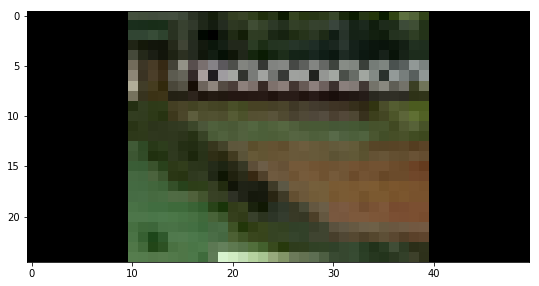

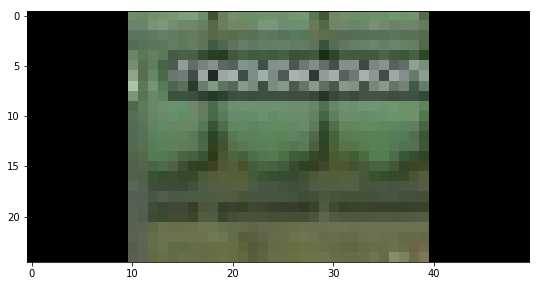

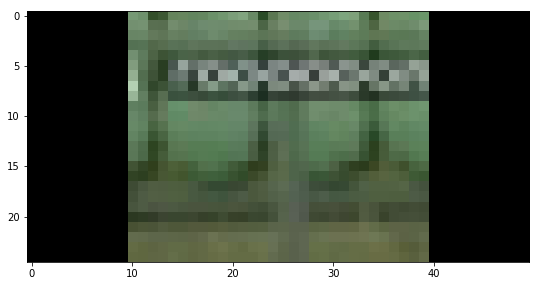

In [39]:
show_event_imgs(FILES[0])

гол (1604, 1605) 2
замена (2190, 2197) 8
желтая карточка (3224, 3226) 3
желтая карточка (3749, 3752) 4
замена (5507, 5510) 4
замена (5795, 5801) 7
замена (6342, 6343) 2
желтая карточка (6353, 6354) 2
желтая карточка (6461, 6463) 3
гол (6753, 6754) 2
замена (6841, 6847) 7
гол (7057, 7058) 2


A Jupyter Widget

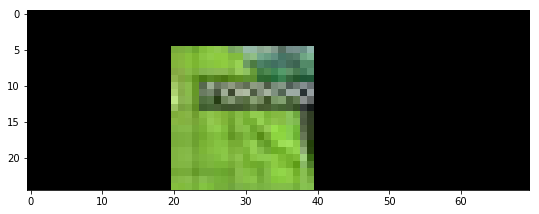

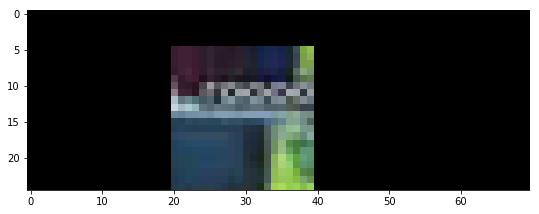

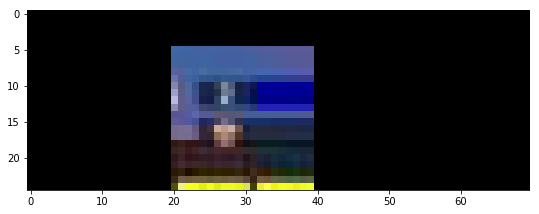

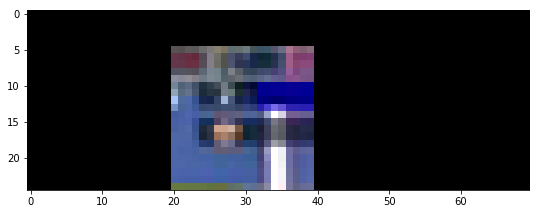

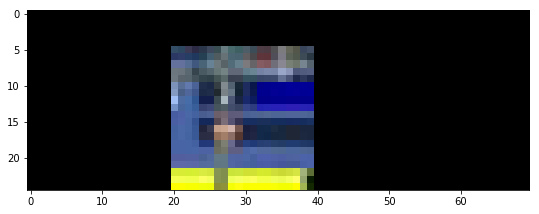

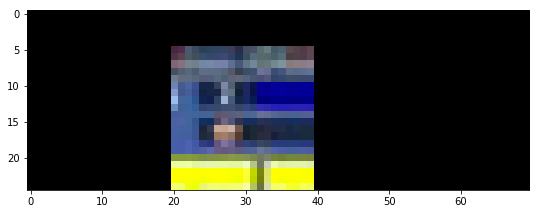

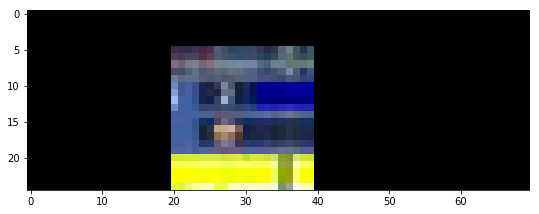

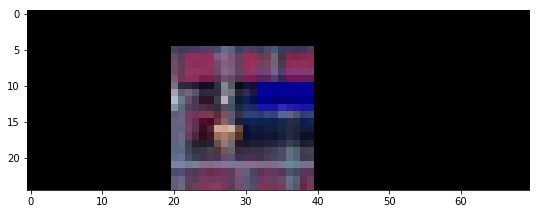

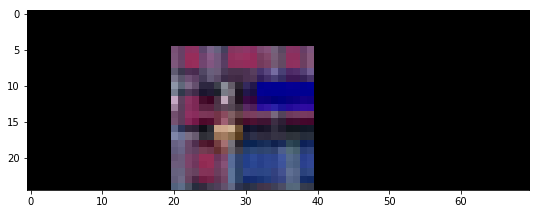

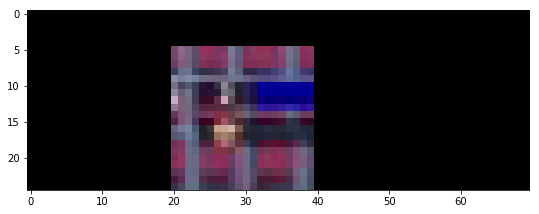

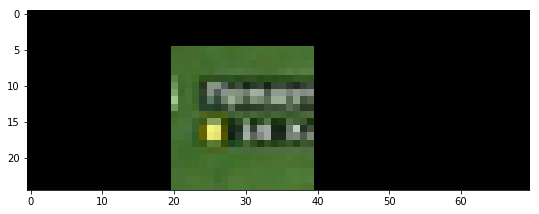

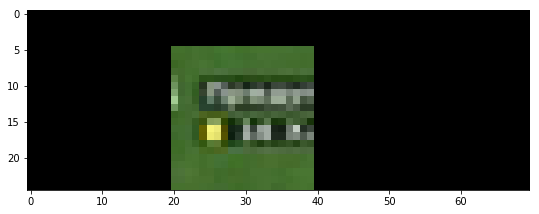

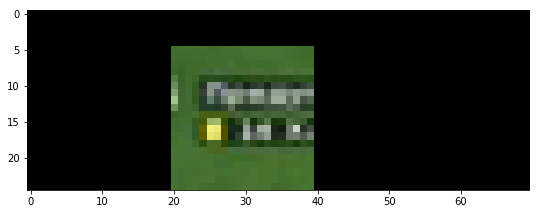

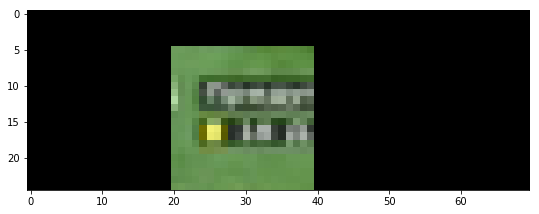

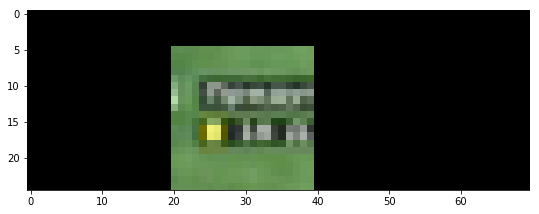

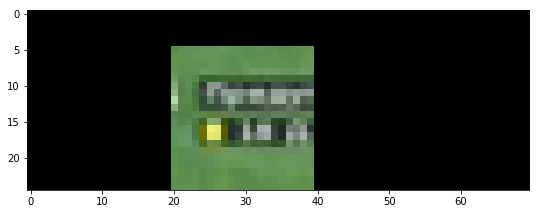

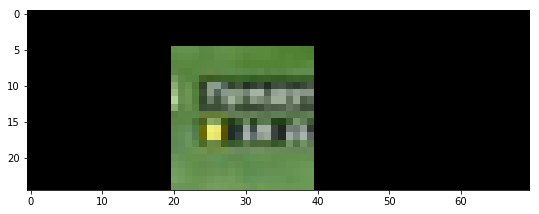

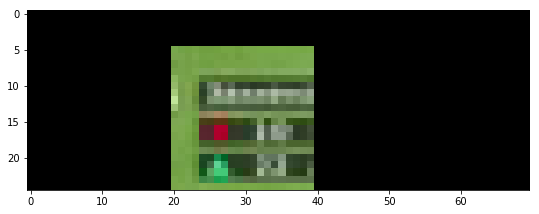

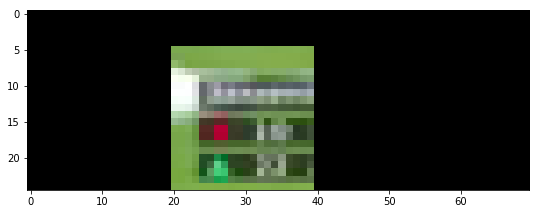

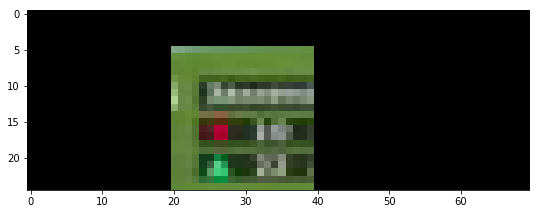

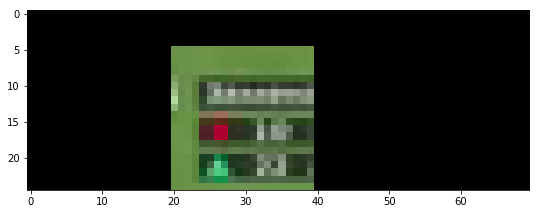

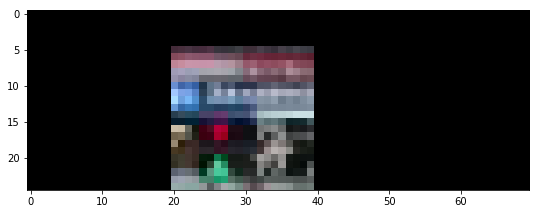

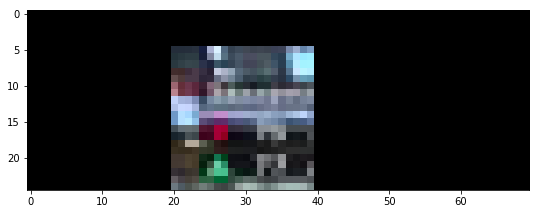

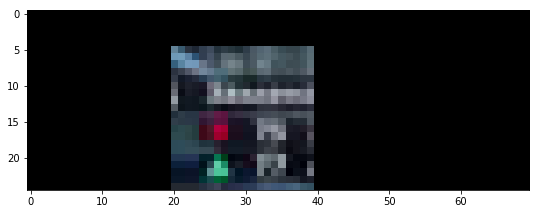

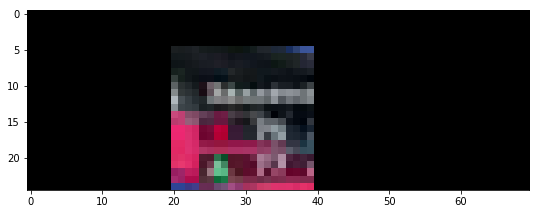

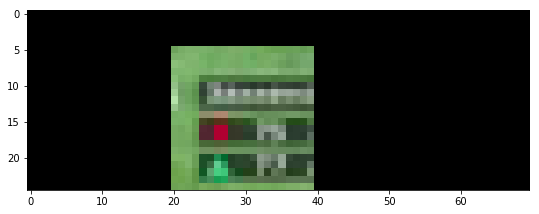

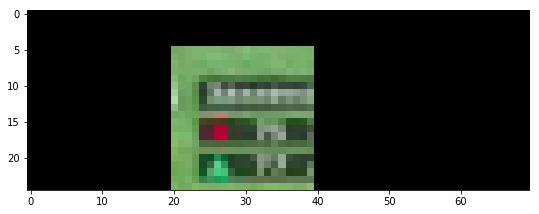

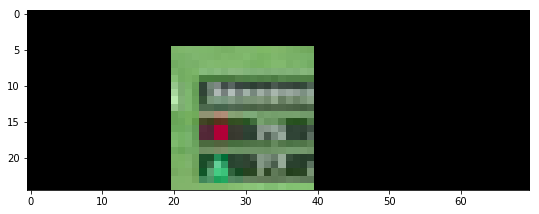

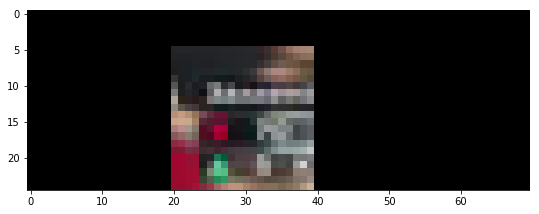

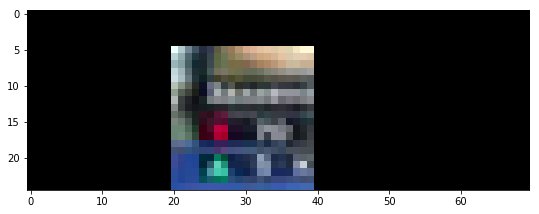

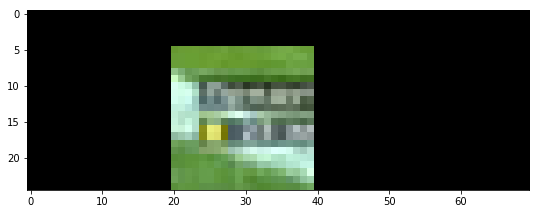

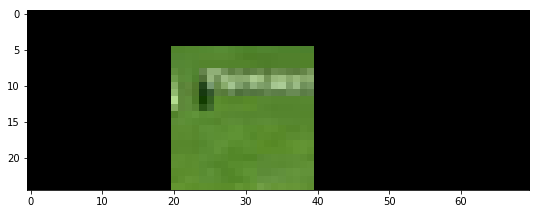

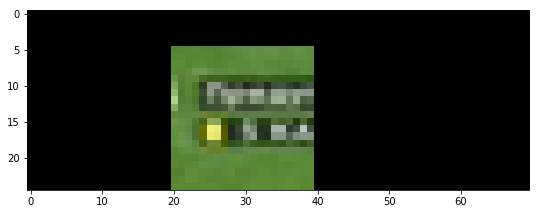

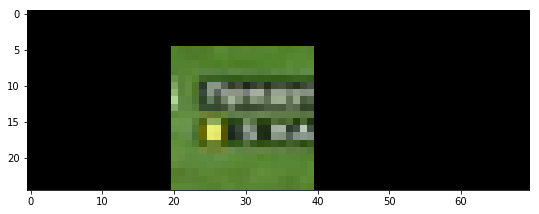

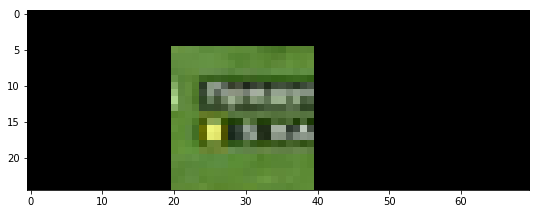

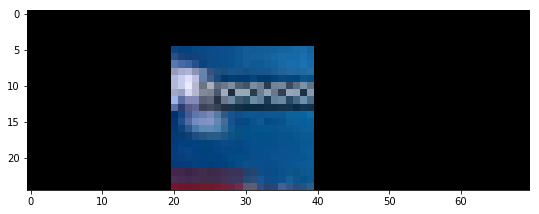

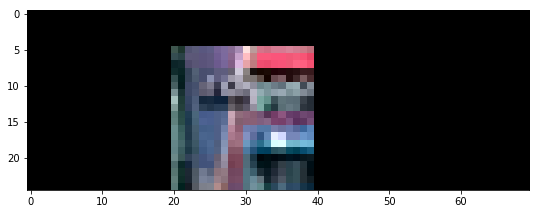

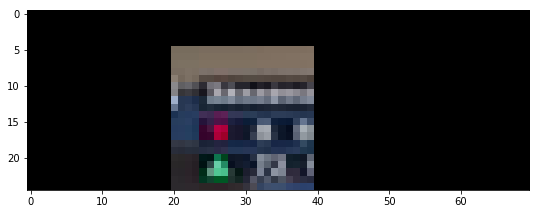

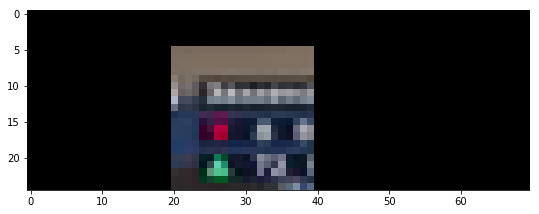

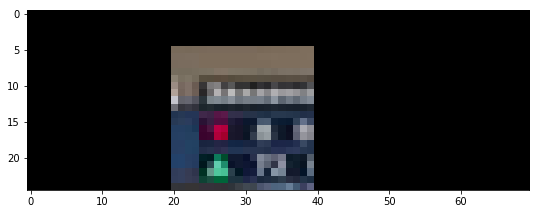

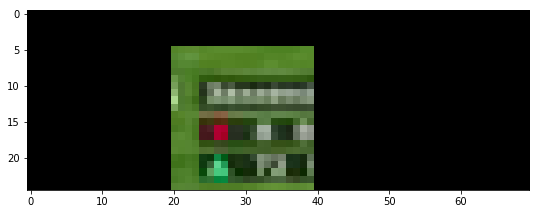

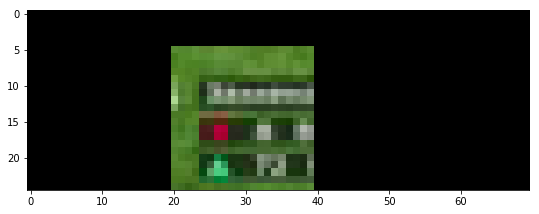

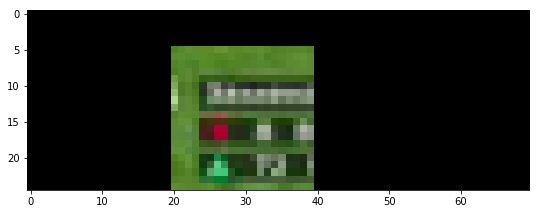

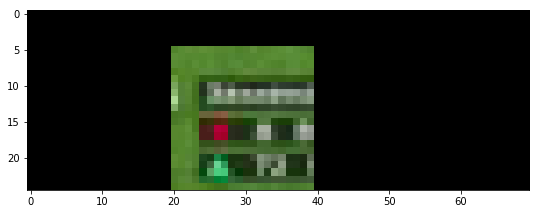

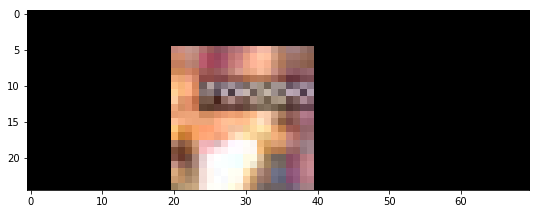

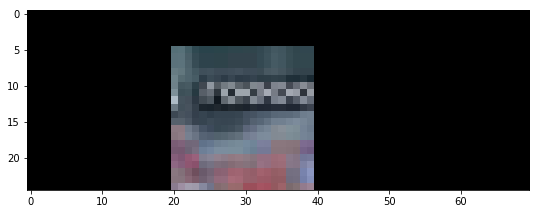

In [103]:
show_event_imgs(FILES[1])

In [36]:
def create_Xy(file_name):
    path = VIDEO_DIR + 'resized_' + file_name
    n_frame = get_total_len(path)
    events_type = [None] * n_frame
    for _, row in full_event_table.iterrows():
        if row.file_name != file_name:
            continue
        l, r = convert_time(row.event_time)+2, convert_time(row.event_end)-1
        for i in range(l, r+1):
            events_type[i] = row.event_type
    X, y = [], []
    bad_pairs = []
    shape_frame = ()
    for frame, event_type in tqdm(zip(get_reader(path), events_type)):
        frame = PREPROC_FUN(frame)
        shape_frame = frame.shape
        if IS_FLATTEN:
            frame = frame.reshape((-1))
        if event_type is None:
            bad_pairs.append((frame, NONE_TYPE))
        else:
            y.append(event_type)
            X.append(frame)
    print(shape_frame)
    #n_pairs = min(int(len(y) * NONK), len(bad_pairs))
    n_pairs = NN
    for i in np.random.choice(range(len(bad_pairs)), n_pairs, replace=False):
        X.append(bad_pairs[i][0])
        y.append(bad_pairs[i][1])
    return X, y

In [37]:
def create_dataset(files):
    X, y, file_name = [], [], []
    for file in tqdm(files):
        X_file, y_file = create_Xy(file)
        print(f'create_dataset: len(y_file)={len(y_file)}')
        X += X_file
        y += y_file
        file_name += [file] * len(y_file)
    return np.array(X), np.array(y), np.array(file_name)

In [38]:
X, y, file_name = create_dataset(FILES)

A Jupyter Widget

A Jupyter Widget

(25, 50, 3)
create_dataset: len(y_file)=1035


A Jupyter Widget

(25, 50, 3)
create_dataset: len(y_file)=1046


A Jupyter Widget

(25, 50, 3)
create_dataset: len(y_file)=1010


A Jupyter Widget

(25, 50, 3)
create_dataset: len(y_file)=1026


A Jupyter Widget

(25, 50, 3)
create_dataset: len(y_file)=1048


A Jupyter Widget

(25, 50, 3)
create_dataset: len(y_file)=1022



In [39]:
print(np.unique(file_name))
print(X.shape)

['645001_5.mp4' '645066_5.mp4' '645098_5.mp4' '645195_5.mp4' '645286_5.mp4'
 '645310_5.mp4']
(6187, 3750)


In [17]:
from sklearn.metrics import f1_score, accuracy_score

def run_cross_val(model, X, y, file_name, count=None):
    X = np.array(X)
    y = np.array(y)
    file_name = np.array(file_name)
    ind = 0
    f1s, acs, nonnan_f1s = [], [], []
    for file in tqdm(np.unique(file_name)):
        if ind == count:
            break
        train_ind = file_name != file
        X_train, y_train, X_test, y_test = X[train_ind], y[train_ind], X[~train_ind], y[~train_ind]
        print('run_cross_val: #{} train_size={} test_size={}'.format(
            ind, len(y_train), len(y_test)), end=' ')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1, ac = f1_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred)
        
        nonan_ind = (y_test != NONE_TYPE) | (y_pred != NONE_TYPE)
        
        nonnan_f1 = f1_score(y_test[nonan_ind], y_pred[nonan_ind], average='macro')
        
        f1s.append(f1)
        acs.append(ac)
        nonnan_f1s.append(nonnan_f1)
        print(f'f1={f1} ac={ac} nonnan_f1={nonnan_f1}')
        
        ind += 1
    return np.mean(f1s), np.mean(acs), np.mean(nonnan_f1s)

In [18]:
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.pipeline import make_pipeline, make_union
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures

In [19]:
def test_models(models, names=None):
    if names is None:
        names = [model.__class__.__name__ for model in models]
    assert(len(models) == len(names))
    scores = []
    for model, name in zip(models, names):
        print(name)
        score = run_cross_val(model, X, y, file_name)
        scores.append((name, score))
        print('Total: f1={:0.5} ac={:0.5} nonan_f1={:0.5}'.format(*score))
        print('#'*30 + '\n'*3)
    return scores

In [40]:
one_ridge = RidgeClassifier(normalize=True, class_weight='balanced')
test_models([one_ridge])

RidgeClassifier


A Jupyter Widget

run_cross_val: #0 train_size=5152 test_size=1035 f1=0.8984690875038388 ac=0.9922705314009662 nonnan_f1=0.6494720965309201
run_cross_val: #1 train_size=5141 test_size=1046 f1=0.8479189580023626 ac=0.9847036328871893 nonnan_f1=0.5999149659863946
run_cross_val: #2 train_size=5177 test_size=1010 f1=0.613949279695136 ac=0.9910891089108911 nonnan_f1=0.3650793650793651
run_cross_val: #3 train_size=5161 test_size=1026 f1=0.9237685893920244 ac=0.9951267056530214 nonnan_f1=0.5912698412698413
run_cross_val: #4 train_size=5139 test_size=1048 f1=0.9100681036870488 ac=0.9961832061068703 nonnan_f1=0.6605691056910569
run_cross_val: #5 train_size=5165 test_size=1022 f1=0.9145981172197931 ac=0.9931506849315068 nonnan_f1=0.6654761904761904

Total: f1=0.85146 ac=0.99209 nonan_f1=0.58863
##############################





[('RidgeClassifier',
  (0.85146202258336723, 0.99208731164840758, 0.58863026083896142))]

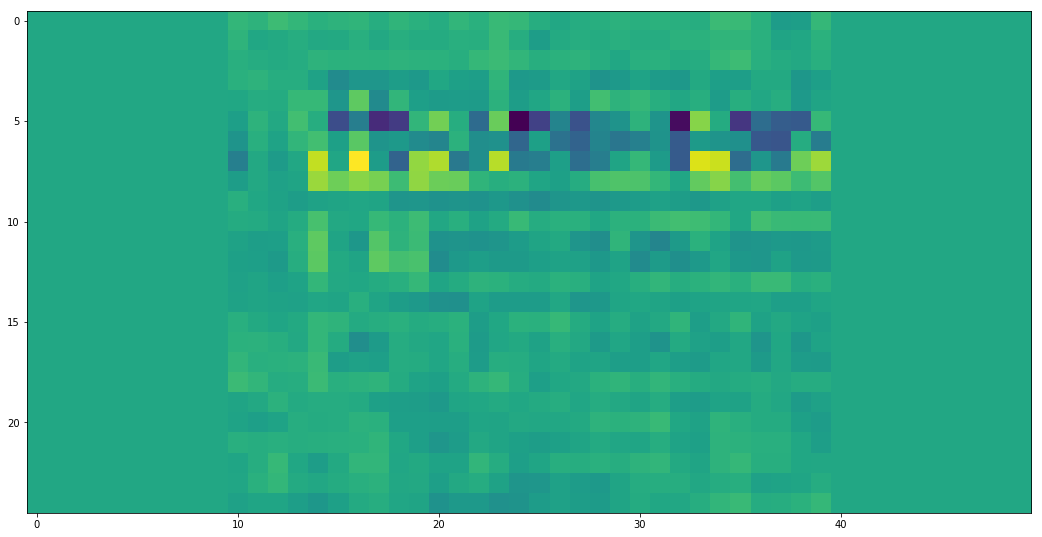

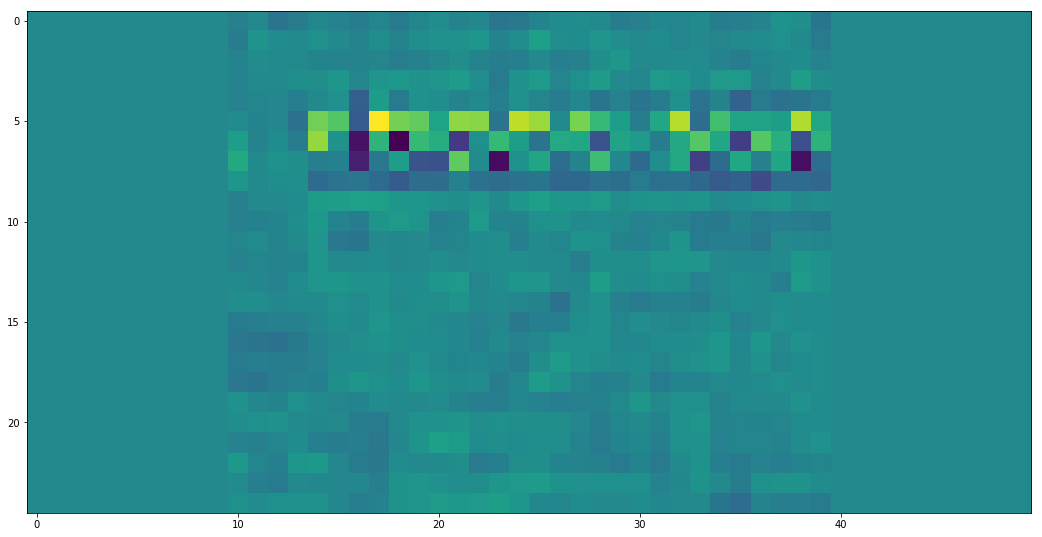

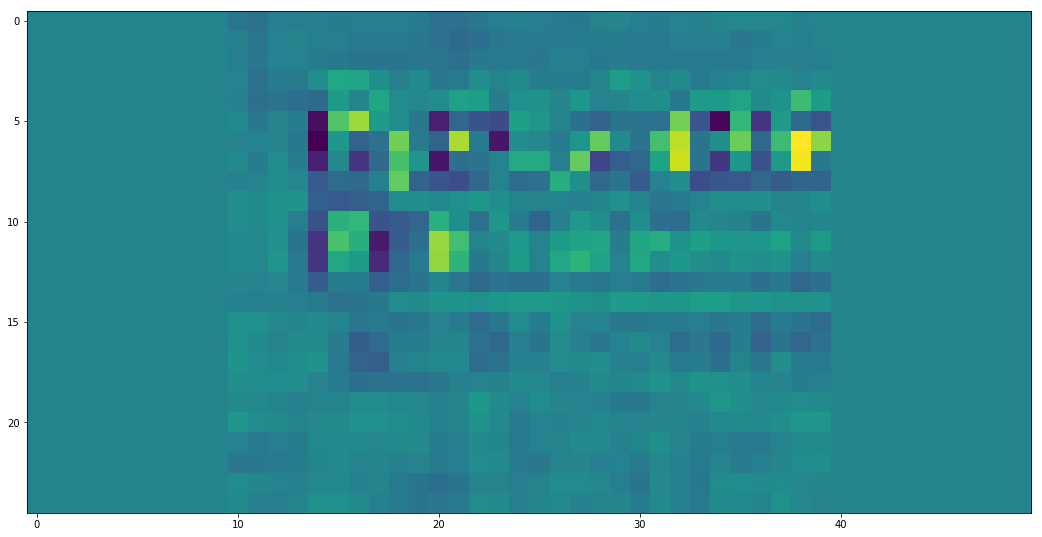

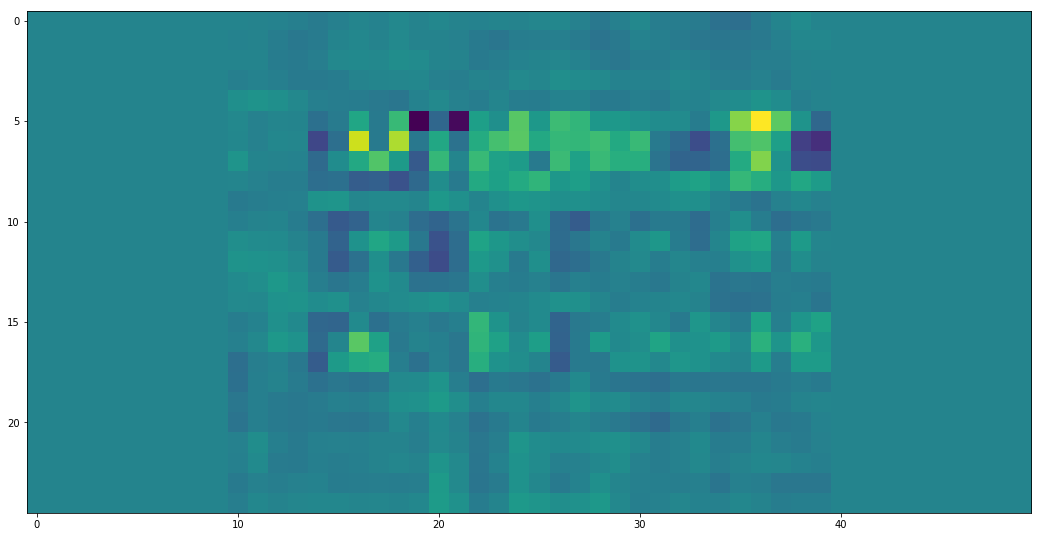

In [52]:
for type_i in range(4):
    coef_img = one_ridge.coef_[type_i].reshape((25, 50, 3))
    show_img(coef_img[:,:,2])

In [161]:
TOO LONG
models = [
    RidgeClassifier(normalize=True, class_weight='balanced'),
    RidgeClassifier(),
    RidgeClassifier(normalize=True),
    LogisticRegression(),
    make_pipeline(GaussianRandomProjection(n_components=100), KNeighborsClassifier()),
    RandomForestClassifier(),
]
test_models(models)

RidgeClassifier


A Jupyter Widget

run_cross_val: #0 train_size=3192 test_size=735 f1=0.8418442871124604 ac=0.9795918367346939 nonnan_f1=0.7333333333333334
run_cross_val: #1 train_size=2961 test_size=966 f1=0.7455211843376957 ac=0.9616977225672878 nonnan_f1=0.6747364953886692
run_cross_val: #2 train_size=3717 test_size=210 f1=0.6987437185929648 ac=0.9904761904761905 nonnan_f1=1.0
run_cross_val: #3 train_size=3381 test_size=546 f1=0.9520607474497963 ac=0.9981684981684982 nonnan_f1=0.6190476190476191
run_cross_val: #4 train_size=2919 test_size=1008 f1=0.9568645640074211 ac=0.9910714285714286 nonnan_f1=1.0
run_cross_val: #5 train_size=3465 test_size=462 f1=0.8072906140102672 ac=0.9675324675324676 nonnan_f1=1.0
Total: f1=0.83372 ac=0.98142 nonan_f1=0.83785
##############################



RidgeClassifier


A Jupyter Widget

run_cross_val: #0 train_size=3192 test_size=735 f1=0.8515133996698745 ac=0.9809523809523809 nonnan_f1=0.7166666666666667
run_cross_val: #1 train_size=2961 test_size=966 f1=0.6750728618590736 ac=0.9451345755693582 nonnan_f1=0.6672871836940746
run_cross_val: #2 train_size=3717 test_size=210 f1=0.7481108312342569 ac=0.9857142857142858 nonnan_f1=1.0
run_cross_val: #3 train_size=3381 test_size=546 f1=0.6749332837518593 ac=0.9908424908424909 nonnan_f1=0.6112956810631229
run_cross_val: #4 train_size=2919 test_size=1008 f1=0.9192295522860308 ac=0.9871031746031746 nonnan_f1=0.7435897435897436
run_cross_val: #5 train_size=3465 test_size=462 f1=0.8533928751267598 ac=0.9675324675324676 nonnan_f1=1.0
Total: f1=0.78704 ac=0.97621 nonan_f1=0.78981
##############################



RidgeClassifier


A Jupyter Widget

run_cross_val: #0 train_size=3192 test_size=735 f1=0.6326074332171894 ac=0.9727891156462585 nonnan_f1=0.4765765765765766
run_cross_val: #1 train_size=2961 test_size=966 f1=0.676736861051116 ac=0.9813664596273292 nonnan_f1=0.447463768115942
run_cross_val: #2 train_size=3717 test_size=210 f1=0.49812967581047385 ac=0.9857142857142858 nonnan_f1=0.3333333333333333
run_cross_val: #3 train_size=3381 test_size=546 f1=0.665389527458493 ac=0.9926739926739927 nonnan_f1=0.3333333333333333
run_cross_val: #4 train_size=2919 test_size=1008 f1=0.7176621755194182 ac=0.9930555555555556 nonnan_f1=0.49683544303797467
run_cross_val: #5 train_size=3465 test_size=462 f1=0.6716139954853274 ac=0.974025974025974 nonnan_f1=0.4722222222222222
Total: f1=0.64369 ac=0.98327 nonan_f1=0.42663
##############################



LogisticRegression


A Jupyter Widget

run_cross_val: #0 train_size=3192 test_size=735 f1=0.7824418387368026 ac=0.9714285714285714 nonnan_f1=0.6583011583011583
run_cross_val: #1 train_size=2961 test_size=966 f1=0.782473635079221 ac=0.974120082815735 nonnan_f1=0.6688311688311688
run_cross_val: #2 train_size=3717 test_size=210 f1=0.6641541038525963 ac=0.9809523809523809 nonnan_f1=0.5555555555555555
run_cross_val: #3 train_size=3381 test_size=546 f1=0.6162533578640961 ac=0.9761904761904762 nonnan_f1=0.555984555984556
run_cross_val: #4 train_size=2919 test_size=1008 f1=0.8788118628992264 ac=0.9871031746031746 nonnan_f1=0.7222222222222222
run_cross_val: #5 train_size=3465 test_size=462 f1=0.7036091642390855 ac=0.9718614718614719 nonnan_f1=0.48901098901098905
Total: f1=0.73796 ac=0.97694 nonan_f1=0.60832
##############################



Pipeline


A Jupyter Widget

run_cross_val: #0 train_size=3192 test_size=735 f1=0.7236878095337862 ac=0.9741496598639455 nonnan_f1=0.5765765765765767
run_cross_val: #1 train_size=2961 test_size=966 f1=0.6690457525348679 ac=0.9813664596273292 nonnan_f1=0.43560606060606055
run_cross_val: #2 train_size=3717 test_size=210 f1=0.6419630548662806 ac=0.9857142857142858 nonnan_f1=0.3111111111111111
run_cross_val: #3 train_size=3381 test_size=546 f1=0.6134860050890585 ac=0.9816849816849816 nonnan_f1=0.2905982905982906
run_cross_val: #4 train_size=2919 test_size=1008 f1=0.7095845398647713 ac=0.9871031746031746 nonnan_f1=0.4642857142857143
run_cross_val: #5 train_size=3465 test_size=462 f1=0.6522265599153048 ac=0.9718614718614719 nonnan_f1=0.44097222222222227
Total: f1=0.66833 ac=0.98031 nonan_f1=0.41986
##############################



RandomForestClassifier


A Jupyter Widget

run_cross_val: #0 train_size=3192 test_size=735 f1=0.7001847095389302 ac=0.9714285714285714 nonnan_f1=0.5428571428571428
run_cross_val: #1 train_size=2961 test_size=966 f1=0.624303560596523 ac=0.9782608695652174 nonnan_f1=0.3863381858902576
run_cross_val: #2 train_size=3717 test_size=210 f1=0.4808457711442786 ac=0.9809523809523809 nonnan_f1=0.3111111111111111
run_cross_val: #3 train_size=3381 test_size=546 f1=0.6400478331430879 ac=0.9871794871794872 nonnan_f1=0.30894308943089427
run_cross_val: #4 train_size=2919 test_size=1008 f1=0.7116467739145476 ac=0.9871031746031746 nonnan_f1=0.4722222222222222
run_cross_val: #5 train_size=3465 test_size=462 f1=0.7835483210483212 ac=0.9783549783549783 nonnan_f1=0.5585858585858585
Total: f1=0.65676 ac=0.98055 nonan_f1=0.43001
##############################





[('RidgeClassifier',
  (0.83372085258510087, 0.98142302400842774, 0.8378529079616035)),
 ('RidgeClassifier',
  (0.78704213398797584, 0.97621322920235964, 0.78980654583560128)),
 ('RidgeClassifier',
  (0.64368994475700292, 0.9832708972072326, 0.42662744610323039)),
 ('LogisticRegression',
  (0.73795732711183792, 0.97694269297530179, 0.60831760831760828)),
 ('Pipeline', (0.66833228696734492, 0.98031333889253158, 0.41985832923332927)),
 ('RandomForestClassifier',
  (0.656762828230948, 0.98054657701396819, 0.43000960168291441))]